In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!unzip '/content/drive/My Drive/VR/Dress Recognition/cropped_images.zip'

Streaming output truncated to the last 5000 lines.
  inflating: cropped_images/saree/1048.png  
  inflating: cropped_images/saree/1049.png  
  inflating: cropped_images/saree/105.png  
  inflating: cropped_images/saree/527.png  
  inflating: cropped_images/saree/532.png  
  inflating: cropped_images/saree/535.png  
  inflating: cropped_images/saree/537.png  
  inflating: cropped_images/saree/1052.png  
  inflating: cropped_images/saree/1053.png  
  inflating: cropped_images/saree/1987.png  
  inflating: cropped_images/saree/1988.png  
  inflating: cropped_images/saree/1989.png  
  inflating: cropped_images/saree/199.png  
  inflating: cropped_images/saree/1990.png  
  inflating: cropped_images/saree/1991.png  
  inflating: cropped_images/saree/1992.png  
  inflating: cropped_images/saree/1993.png  
  inflating: cropped_images/saree/1994.png  
  inflating: cropped_images/saree/1995.png  
  inflating: cropped_images/saree/1996.png  
  inflating: cropped_images/saree/1997.png  
  inflatin

In [0]:
import tensorflow as tf
import os
import time
os.environ["TF_CPP_MIN_LOG_LEVEL"]= "2"
print("tensorflow Version is: " + str(tf.__version__))

import numpy as np
os.environ['KERAS_BACKEND'] = 'tensorflow'
from keras import backend as K
print(os.environ['KERAS_BACKEND'])

tensorflow Version is: 2.2.0
tensorflow


Using TensorFlow backend.


In [0]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import utils, losses, optimizers
import matplotlib.pyplot as plt

In [0]:
import os
import glob 
# import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

Loading Dataset

In [0]:
image_dir_training = "/content/cropped_images"

def load_dataset(image_dir):
    '''This function loads in images and their labels and places them in a list
    im_list[0][:] will be the first image-label pair in the list'''
    
    im_list = []
    labels = []
    image_types = ["kurti","none","saree","shirt","tshirt"]
    
    # Iterate through each color folder
    for im_type in image_types:
        
        # Iterate through each image file in each image_type folder
        # glob reads in any image with the extension "image_dir/im_type/*"
        for file in glob.glob(os.path.join(image_dir, im_type, "*")):
            
            # Read in the image
            img = cv2.imread(file)
            im = cv2.resize(img, (200, 300))
            
            # Check if the image exists/if it's been correctly read-in
            if not im is None:
                # Append the image, and it's type to image list and labels
                im_list.append((im))
                labels.append(im_type)
    
    return im_list,labels

img_list, labels = load_dataset(image_dir_training)

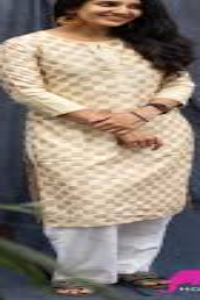

In [0]:
cv2_imshow(img_list[45])
# Images are stored as -
# img_list[3] - Image 3
# img_list[3].shape - (300,200) i.e. shape of image 3 (height,width)

Splitting dataset into test and train

In [0]:
train_ratio = 0.6
valid_ratio = 0.1
test_ratio = 0.3

def train_test_valid_split(X, Y):
  left_X, valid_X, left_y, valid_y = train_test_split(X, Y, test_size=valid_ratio)
  train_X, test_X, train_y, test_y = train_test_split(left_X, left_y, test_size=test_ratio / (test_ratio + train_ratio))
  return test_X, test_y, train_X, train_y, valid_X, valid_y

X_test, Y_test, X_train, Y_train, X_valid, Y_valid = train_test_valid_split(img_list, labels)

In [0]:
# Type Conversion
x_train = np.asarray(X_train,'float32')
x_test = np.asarray(X_test,'float32')
x_valid = np.asarray(X_valid,'float32')

In [0]:
# Scaling data
x_train /= 255
x_test /= 255
x_valid /= 255

In [0]:
# Label Encoding:
le = LabelEncoder()
y_valid = le.fit_transform(Y_valid)
y_test = le.fit_transform(Y_test)
y_train = le.fit_transform(Y_train)

In [0]:
# One Hot Encoding
num_classes = 5
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test,  num_classes)
y_valid = utils.to_categorical(y_valid,  num_classes)

In [0]:
# Changing shape of train data to (rows, columns, channel_Size) 
img_rows = 300
img_cols = 200
x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols,3)
x_test = x_test.reshape(x_test.shape[0],img_rows, img_cols,3)
x_valid = x_valid.reshape(x_valid.shape[0],img_rows, img_cols,3)
input_shape = (img_rows, img_cols,3)

In [0]:
#Define the CNN model
model = Sequential()

model.add(Conv2D(32, kernel_size=(3,3), activation = 'relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, kernel_size=(3,3), activation = 'relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())
model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 298, 198, 32)      896       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 149, 99, 32)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 147, 97, 32)       9248      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 73, 48, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 71, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 35, 23, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 33, 21, 64)       

In [0]:
#compile - how to measure loss
model.compile(loss=losses.categorical_crossentropy, optimizer='rmsprop', metrics=['accuracy'])

In [0]:
batch_size = 16
epochs = 50

In [0]:
#train the model and return loss and accuracy for each epoch - history dictionary
start = time.time()
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(x_valid,y_valid))
end = time.time()

Train on 3829 samples, validate on 639 samples
Epoch 1/50
3829/3829 [==============================] - 15s 4ms/step - loss: 1.4294 - accuracy: 0.3722 - val_loss: 1.1946 - val_accuracy: 0.5399
Epoch 2/50
3829/3829 [==============================] - 8s 2ms/step - loss: 1.1378 - accuracy: 0.5411 - val_loss: 1.0616 - val_accuracy: 0.6103
Epoch 3/50
3829/3829 [==============================] - 7s 2ms/step - loss: 0.9793 - accuracy: 0.6124 - val_loss: 0.9627 - val_accuracy: 0.6432
Epoch 4/50
3829/3829 [==============================] - 7s 2ms/step - loss: 0.8501 - accuracy: 0.6647 - val_loss: 0.8973 - val_accuracy: 0.6714
Epoch 5/50
3829/3829 [==============================] - 7s 2ms/step - loss: 0.7467 - accuracy: 0.7195 - val_loss: 0.8909 - val_accuracy: 0.6917
Epoch 6/50
3829/3829 [==============================] - 7s 2ms/step - loss: 0.6695 - accuracy: 0.7482 - val_loss: 0.8301 - val_accuracy: 0.7058
Epoch 7/50
3829/3829 [==============================] - 7s 2ms/step - loss: 0.5920 - acc

In [0]:
model.save_weights('first_simple_try.h5')

In [0]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test Loss: ', score[0])
print('Test Accuracy: ', score[1])
print('Time to run: ', (end-start))

Test Loss:  2.623274367907651
Test Accuracy:  0.697650134563446
Time to run:  375.00995445251465
